In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score, pairwise_distances_argmin_min
import statsmodels.api as sm
import patsy
import networkx as nx
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [3]:
# Loading the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

print('Data Shape: ', mcdonalds.shape)
print('Features: ', list(mcdonalds.columns))

Data Shape:  (1453, 15)
Features:  ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']


In [4]:
mcdonalds.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [5]:
# Convert Yes/No responses to binary
MD_x = mcdonalds.iloc[:, :11].apply(lambda x: x == "Yes").astype('int')
mcdonalds[MD_x.columns] = MD_x.astype('int')

In [6]:
# Mapping Categorical variables to numeric values
visit_frequency_mapping = {
    'Never': 0,
    'Once a year': 1,
    'Every three months': 2,
    'Once a month': 3,
    'Once a week': 4,
    'More than once a week': 5
}

like_mapping = {
    'I hate it!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '+1': 1,
    '+2': 2,
    '+3': 3,
    '+4': 4,
    'I love it!+5': 5,
}

gender_mapping = {
    'Female': 1,
    'Male': 2
}

mcdonalds['Like'] = mcdonalds['Like'].map(like_mapping)
mcdonalds['VisitFrequency'] = mcdonalds['VisitFrequency'].map(visit_frequency_mapping)
mcdonalds['Gender'] = mcdonalds['Gender'].map(gender_mapping)

In [7]:
mcdonalds.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,2,1
1,1,1,0,1,1,1,1,1,1,0,0,2,51,2,1
2,0,1,1,1,1,1,0,1,1,1,0,1,62,2,1
3,1,1,0,1,1,1,1,1,0,0,1,4,69,4,1
4,0,1,0,1,1,1,1,0,0,1,0,2,49,3,2


In [8]:
MD_x.mean().round(2)

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

PCA

In [9]:
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Summary of PCA
summary_df = pd.DataFrame({
    'Standard Deviation': np.sqrt(explained_variance),
    'Proportion of Variance': explained_variance_ratio,
    'Cumulative Proportion': cumulative_variance_ratio
})

summary_df

,Standard Deviation,Proportion of Variance,Cumulative Proportion
0,0.757050,0.299447,0.299447
1,0.607456,0.192797,0.492244
2,0.504619,0.133045,0.625290
3,0.398799,0.083096,0.708386
4,0.337405,0.059481,0.767866
5,0.310275,0.050300,0.818166
6,0.289697,0.043849,0.862015
7,0.275122,0.039548,0.901563
8,0.265251,0.036761,0.938323
9,0.248842,0.032353,0.970677


The first two principal components together explain around 50% of the variance.

In [10]:
# Rotation matrix
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=MD_x.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
loadings_df.round(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,-0.48,0.36,-0.30,0.06,-0.31,0.17,-0.28,0.01,0.57,-0.11,0.05
convenient,-0.16,0.02,-0.06,-0.14,0.28,-0.35,-0.06,-0.11,-0.02,-0.67,-0.54
spicy,-0.01,0.02,-0.04,0.20,0.07,-0.36,0.71,0.38,0.40,-0.08,0.14
fattening,0.12,-0.03,-0.32,-0.35,-0.07,-0.41,-0.39,0.59,-0.16,-0.01,0.25
greasy,0.30,-0.06,-0.80,0.25,0.36,0.21,0.04,-0.14,-0.00,0.01,0.00
fast,-0.11,-0.09,-0.06,-0.10,0.11,-0.59,-0.09,-0.63,0.17,0.24,0.34
cheap,-0.34,-0.61,-0.15,0.12,-0.13,-0.10,-0.04,0.14,0.08,0.43,-0.49
tasty,-0.47,0.31,-0.29,-0.00,-0.21,-0.08,0.36,-0.07,-0.64,0.08,0.02
expensive,0.33,0.60,0.02,0.07,-0.00,-0.26,-0.07,0.03,0.07,0.45,-0.49
healthy,-0.21,0.08,0.19,0.76,0.29,-0.18,-0.35,0.18,-0.19,-0.04,0.16


The first principal component (PC1) has high values for yummy, tasty and disgusting => these features contribute most to the variance captured by PC1

The second principal component (PC2) has high positive values for expensive and cheap => suggesting a price perception dimension

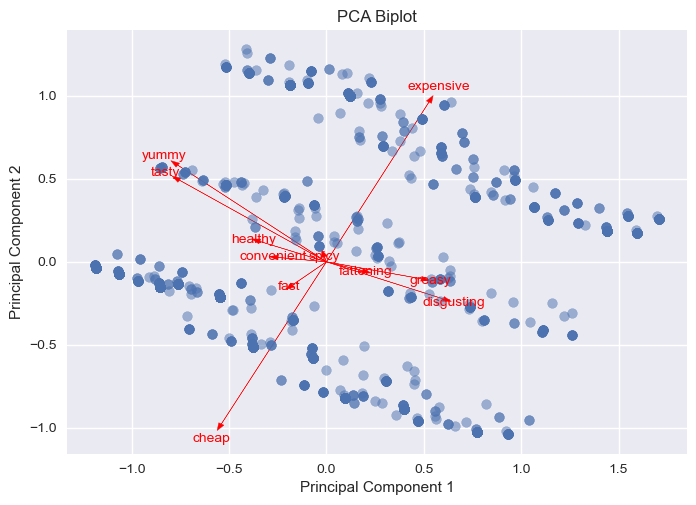

In [11]:
for i, feature in enumerate(MD_x.columns):
    plt.arrow(0, 0, loadings[i, 0] * 1.6, loadings[i, 1] * 1.6, color='r', head_width=0.03)
    plt.text(loadings[i, 0] * 1.75, loadings[i, 1] * 1.75, feature, color='r', ha='center', va='center')
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot')
plt.show()

KMeans

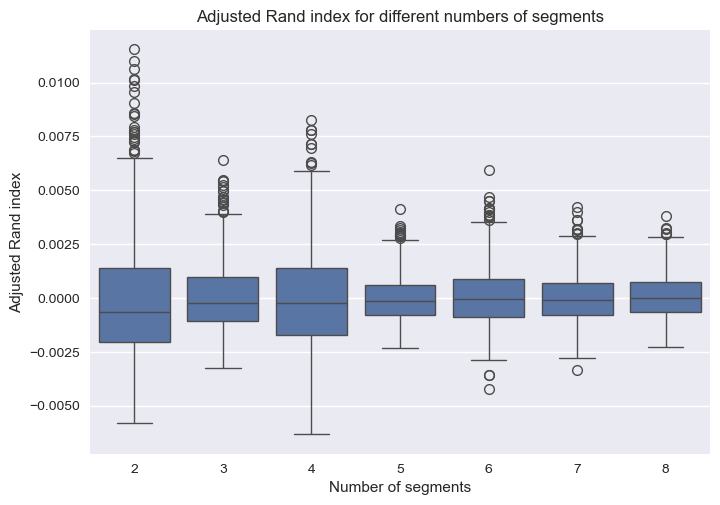

In [12]:
np.random.seed(42)
n_clusters_range = range(2, 9)
n_bootstraps = 100
n_repeats = 10
ari_results = {k: [] for k in n_clusters_range}

for n_clusters in n_clusters_range:
    for _ in range(n_repeats):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(MD_x)
        original_labels = kmeans.labels_
        
        for _ in range(n_bootstraps):
            MD_x_bootstrap = resample(MD_x)
            kmeans_bootstrap = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans_bootstrap.fit(MD_x_bootstrap)
            bootstrap_labels = kmeans_bootstrap.labels_
            ari = adjusted_rand_score(original_labels, bootstrap_labels)
            ari_results[n_clusters].append(ari)

ari_df = pd.DataFrame([(k, ari) for k in ari_results for ari in ari_results[k]], columns=['number_of_segments', 'adjusted_rand_index'])
sns.boxplot(x='number_of_segments', y='adjusted_rand_index', data=ari_df)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand index')
plt.title('Adjusted Rand index for different numbers of segments')
plt.show()

Values are around zero

No clear conclusion can be made from this

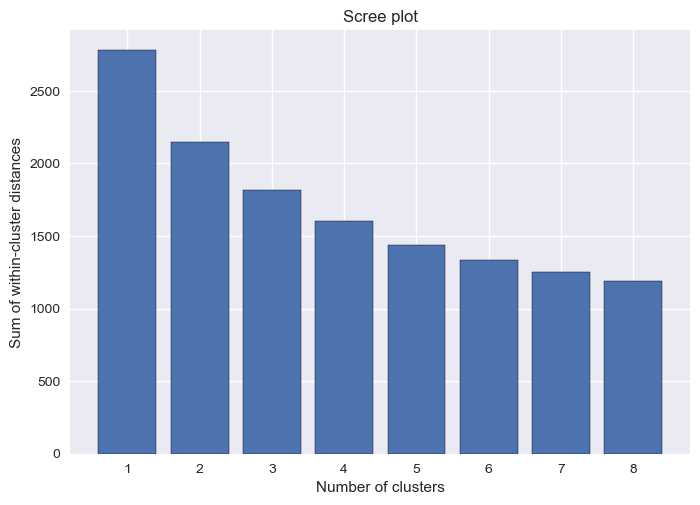

In [13]:
# Elbow method for KMeans clustering
within_cluster_sums = []
for n_clusters in range(1, 9):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1234, n_init=10)
    clusterer.fit(MD_x)
    within_cluster_sums.append(clusterer.inertia_)
plt.bar(range(1, 9), within_cluster_sums, edgecolor='black')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of within-cluster distances')
plt.title('Scree plot')
plt.grid(True)
plt.show()

The elbow is around 4 clusters => this is good for further cluster analysis

In [14]:
# Similarity matrix function
def calculate_similarity(cluster_labels1, cluster_labels2):
    n_clusters1 = len(np.unique(cluster_labels1))
    n_clusters2 = len(np.unique(cluster_labels2))
    similarity_matrix = np.zeros((n_clusters1, n_clusters2))
    for i in range(n_clusters1):
        for j in range(n_clusters2):
            common_elements = np.sum((cluster_labels1 == i) & (cluster_labels2 == j))
            similarity_matrix[i, j] = common_elements
    return similarity_matrix / np.sum(similarity_matrix)

# Segment Level Stability Across Solutions (SLSA) plot
cluster_labels_list = []
for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1234, n_init=10)
    kmeans.fit(MD_x)
    cluster_labels_list.append(kmeans.labels_)
similarity_matrices = []
for i in range(len(cluster_labels_list) - 1):
    similarity_matrices.append(calculate_similarity(cluster_labels_list[i], cluster_labels_list[i + 1]))

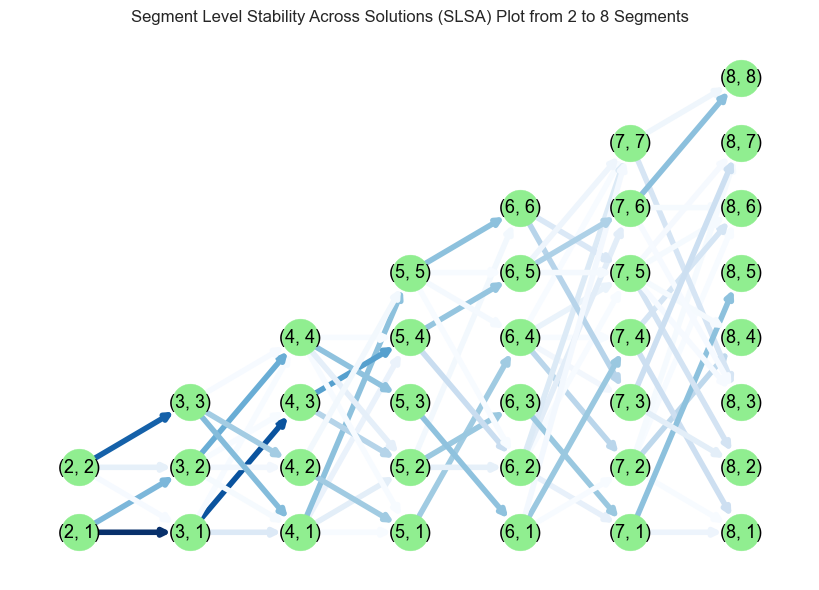

In [15]:
G = nx.DiGraph()
for i in range(len(cluster_labels_list) - 1):
    for j in range(cluster_labels_list[i].max() + 1):
        for k in range(cluster_labels_list[i + 1].max() + 1):
            weight = similarity_matrices[i][j, k]
            if weight > 0:
                G.add_edge((i+2, j + 1), (i + 3, k + 1), weight=weight)
pos = {}
for i in range(len(cluster_labels_list)):
    pos.update({(i+2, j + 1): (i, j + 1) for j in range(cluster_labels_list[i].max() + 1)})
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, pos, node_color='lightgreen', with_labels=True, node_size=700, font_size=13, edge_color=weights, edge_cmap=plt.cm.Blues, width=4.0)
plt.title('Segment Level Stability Across Solutions (SLSA) Plot from 2 to 8 Segments')
plt.show()

Gaussian Mixture Models

In [16]:
def fit_gmm_models(X, n_components_range, n_init=10):
    models = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, n_init=n_init, random_state=1234)
        gmm.fit(X)
        models.append(gmm)
    return models
n_components_range = range(2, 9)
gmm_models = fit_gmm_models(MD_x, n_components_range, n_init=10)

In [17]:
def calculate_icl(gmm, X):
    log_likelihood = gmm.score(X) * X.shape[0]
    bic_term = gmm.n_components * np.log(X.shape[0])
    responsibilities = gmm.predict_proba(X)
    entropy_term = -np.sum(responsibilities * np.log(responsibilities + 1e-10))
    return -2 * log_likelihood + bic_term - 2 * entropy_term

# AIC, BIC, and ICL for different GMMs
aic_values = [model.aic(MD_x) for model in gmm_models]
bic_values = [model.bic(MD_x) for model in gmm_models]
icl_values = [calculate_icl(model, MD_x) for model in gmm_models]

In [18]:
summary_df = pd.DataFrame({
    'n_components': n_components_range,
    'AIC': aic_values,
    'BIC': bic_values,
    'ICL': icl_values
})

summary_df

,n_components,AIC,BIC,ICL
0,2,-21985.641850,-21167.027072,-22281.079086
1,3,-27786.899425,-26556.336565,-28231.056549
2,4,-34405.083804,-32762.572863,-34999.370340
3,5,-44223.863382,-42169.404358,-44965.686000
4,6,-56110.084021,-53643.676917,-57000.403968
5,7,-58214.952914,-55336.597727,-59254.445611
6,8,-52183.620368,-48893.317099,-53372.934088


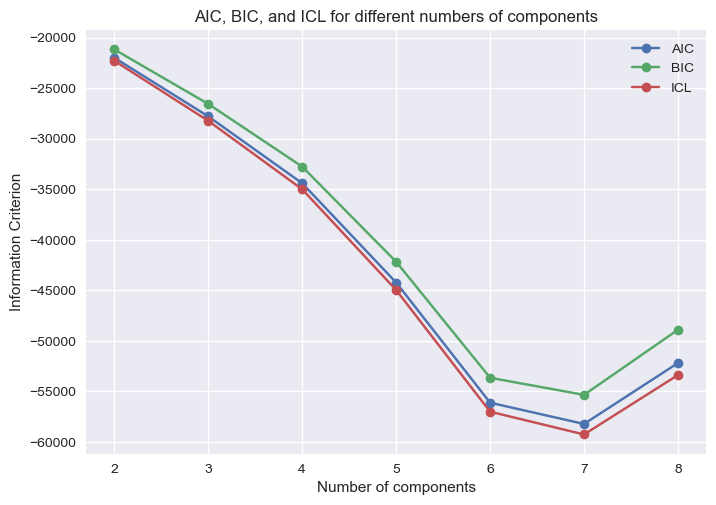

In [19]:
plt.plot(n_components_range, aic_values, marker='o', label='AIC')
plt.plot(n_components_range, bic_values, marker='o', label='BIC')
plt.plot(n_components_range, icl_values, marker='o', label='ICL')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.title('AIC, BIC, and ICL for different numbers of components')
plt.legend()
plt.show()

Suggests that best model would be with 6 components

In [20]:
# 6 segments

# Fit KMeans model
kmeans = KMeans(n_clusters=6, n_init=10, random_state=1234)
kmeans.fit(MD_x)
kmeans_labels = kmeans.labels_

gmm1 = gmm_models[4]
gmm1_labels = gmm1.predict(MD_x)

print(f"Converged: {gmm1.converged_}")

gmm1_clusters = np.unique(gmm1_labels)
print(f"GMM clusters: {gmm1_clusters}")

contingency_table = pd.crosstab(kmeans_labels, gmm1_labels, rownames=['kmeans'], colnames=['mixture'])
print("Contingency Table:")
print(contingency_table)

Converged: True
GMM clusters: [0 1 2 3 4 5]
Contingency Table:
mixture    0   1   2    3    4    5
kmeans                             
0          0  24  10    0    0  220
1        132  30   2    0   17   24
2        140  16   5    0   34   42
3          0   6  23  162    9   39
4        142  14   7    0   49   33
5          0   1  31    0  230   11


In [21]:
# 6 segments, initialized with KMeans centers

kmeans_centers = kmeans.cluster_centers_

# Fit GMM model
gmm2 = GaussianMixture(n_components=6, means_init=kmeans_centers, random_state=1234, n_init=20)
gmm2_labels = gmm2.fit_predict(MD_x)

print(f"Converged: {gmm2.converged_}")

gmm2_clusters = np.unique(gmm2_labels)
print(f"GMM clusters: {gmm2_clusters}")

contingency_table = pd.crosstab(kmeans_labels, gmm2_labels, rownames=['kmeans'], colnames=['mixture'])
print("Contingency Table:")
print(contingency_table)

Converged: True
GMM clusters: [0 1 2 3 4 5]
Contingency Table:
mixture    0    1    2    3   4    5
kmeans                              
0        254    0    0    0   0    0
1         20  141   27    0  15    2
2         24    0  165    0  48    0
3         26    0    0  212   1    0
4         16    0  185    0  44    0
5         17    0    5   59   1  191


In [22]:
# 4 segments

kmeans = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans.fit(MD_x)
kmeans_labels = kmeans.labels_

gmm3 = gmm_models[2]
gmm3_labels = gmm3.predict(MD_x)

print(f"Converged: {gmm3.converged_}")

gmm3_clusters = np.unique(gmm3_labels)
print(f"GMM clusters: {gmm3_clusters}")

contingency_table = pd.crosstab(kmeans_labels, gmm3_labels, rownames=['kmeans'], colnames=['mixture'])
print("Contingency Table:")
print(contingency_table)

Converged: True
GMM clusters: [0 1 2 3]
Contingency Table:
mixture    0    1    2    3
kmeans                     
0         31   51  268   14
1          4  214    0   22
2        143    0  362   28
3          0    3    0  313


In [23]:
# 4 segments, initialized with KMeans centers

kmeans_centers = kmeans.cluster_centers_

# Fit GMM model 
gmm4 = GaussianMixture(n_components=4, means_init=kmeans_centers, random_state=1234, n_init=10)
gmm4_labels = gmm4.fit_predict(MD_x)

print(f"Converged: {gmm4.converged_}")

gmm4_clusters = np.unique(gmm4_labels)
print(f"GMM clusters: {gmm4_clusters}")

contingency_table = pd.crosstab(kmeans_labels, gmm4_labels, rownames=['kmeans'], colnames=['mixture'])
print("Contingency Table:")
print(contingency_table)

Converged: True
GMM clusters: [0 1 2 3]
Contingency Table:
mixture    0    1    2    3
kmeans                     
0        352    5    0    7
1         24  211    0    5
2         18    0  482   33
3          2   38   20  256


In [24]:
# Adding cluster labels to original data
mcdonalds['gmm_init_km_cluster'] = gmm4_labels

summary = mcdonalds.groupby('gmm_init_km_cluster').mean()
summary.round(2)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
gmm_init_km_cluster,,,,,,,,,,,,,,,
0,0.0,0.89,0.08,0.89,0.56,0.93,0.83,0.31,0.00,0.10,0.35,-1.21,49.49,1.64,1.42
1,0.0,0.72,0.11,0.92,0.69,0.76,0.09,0.22,1.00,0.07,0.59,-2.18,48.37,1.67,1.61
2,1.0,1.00,0.08,0.81,0.40,0.96,0.90,1.00,0.00,0.32,0.05,2.90,42.09,3.03,1.39
3,1.0,0.93,0.12,0.88,0.55,0.88,0.22,0.84,0.88,0.24,0.13,2.35,39.19,2.88,1.50


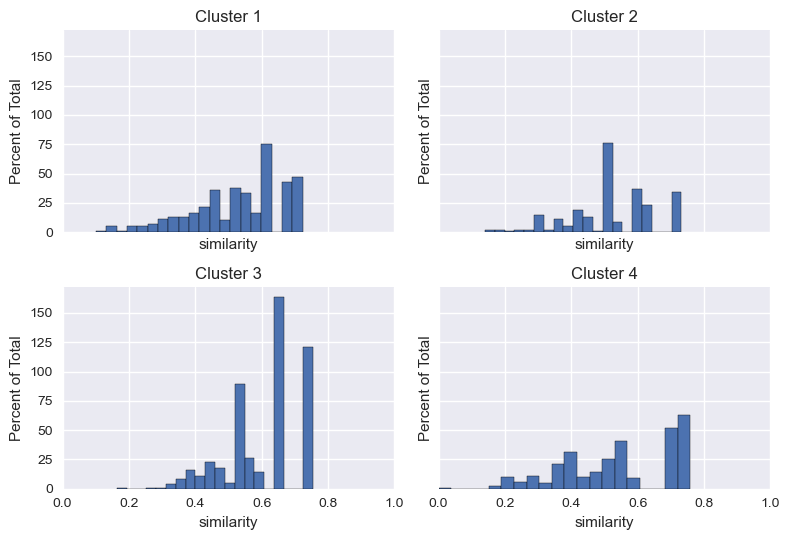

In [25]:
n_clusters = 4
_, distances = pairwise_distances_argmin_min(MD_x, kmeans_centers)
similarities = 1 - (distances / distances.max())

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()
for i in range(n_clusters):
    cluster_similarities = similarities[gmm4_labels == i]
    axes[i].hist(cluster_similarities, bins=20, edgecolor='black')
    axes[i].set_title(f'Cluster {i+1}')
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel('similarity')
    axes[i].set_ylabel('Percent of Total')
plt.tight_layout()
plt.show()

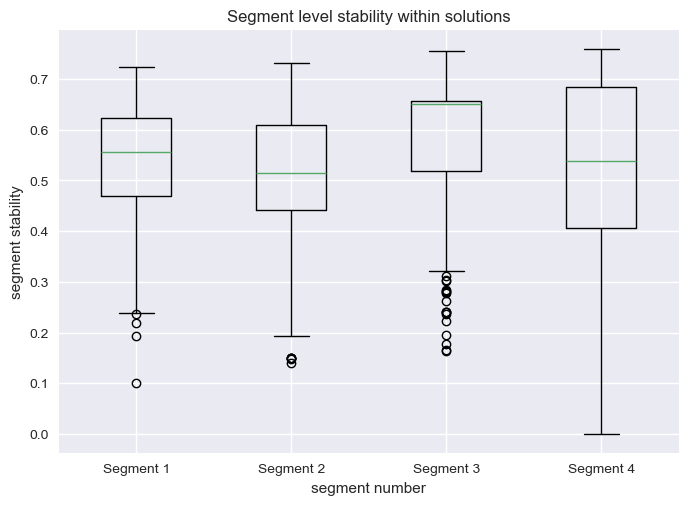

In [26]:
# Segment stability
segment_stability = np.array([np.mean(similarities[kmeans_labels == i]) for i in range(n_clusters)])
plt.boxplot([similarities[kmeans_labels == i] for i in range(4)], labels=[f'Segment {i + 1}' for i in range(n_clusters)])
plt.xlabel('segment number')
plt.ylabel('segment stability')
plt.title('Segment level stability within solutions')
plt.show()

In [27]:
predictor_columns = MD_x.columns
formula = "Like ~ " + " + ".join(predictor_columns)

y, X = patsy.dmatrices(formula, data=mcdonalds, return_type='dataframe')
X = X.values


# Fit regression models for each cluster
models = []
for cluster_num in range(n_clusters):
    data_cluster = mcdonalds[mcdonalds['gmm_init_km_cluster'] == cluster_num]
    y_cluster, X_cluster = patsy.dmatrices(formula, data=data_cluster, return_type='dataframe')
    model = sm.OLS(y_cluster, X_cluster).fit()
    models.append(model)

In [28]:
all_predictors = list(set(p for model in models for p in model.params.index))
coefficients = []
errors = []

for model in models:
    coefficients.append([model.params.get(p, 0) for p in all_predictors])
    errors.append([model.bse.get(p, 0) for p in all_predictors])

coefficients = np.array(coefficients)
errors = np.array(errors)

In [29]:
for i, model in enumerate(models):
    print(f"Summary for Cluster {i+1}:")
    print(model.summary())
    print("\n")

Summary for Cluster 1:
                            OLS Regression Results                            
Dep. Variable:                   Like   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     28.79
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           3.39e-38
Time:                        22:54:25   Log-Likelihood:                -839.78
No. Observations:                 396   AIC:                             1700.
Df Residuals:                     386   BIC:                             1739.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9284      0.

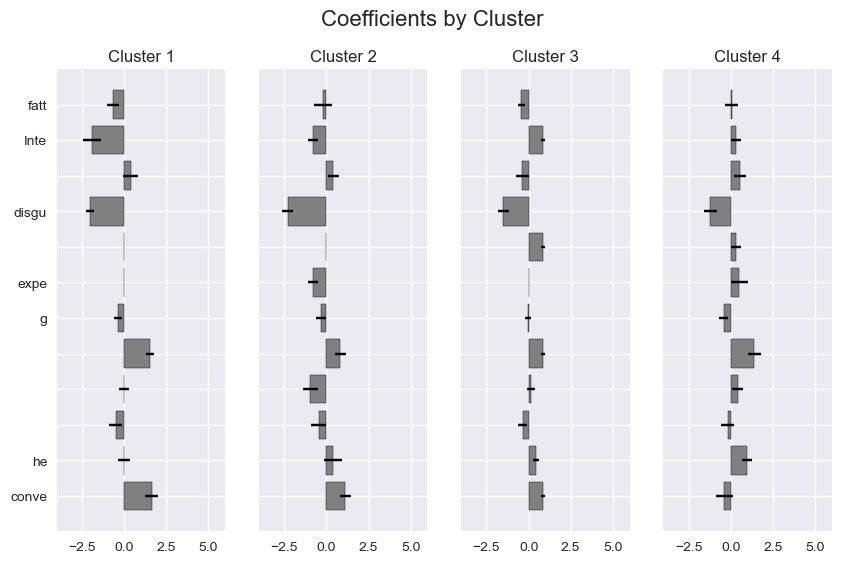

In [30]:
fig, axes = plt.subplots(1, n_clusters, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes):
    ax.barh(range(len(all_predictors)), coefficients[i], xerr=errors[i], capsize=5, color='gray', edgecolor='black')
    ax.set_xlim([-4, 6])
    ax.set_title(f'Cluster {i+1}')
    ax.set_yticks(range(len(all_predictors)))
    ax.set_yticklabels([x[:-5] for x in all_predictors])

fig.suptitle('Coefficients by Cluster', fontsize=16)
plt.show()

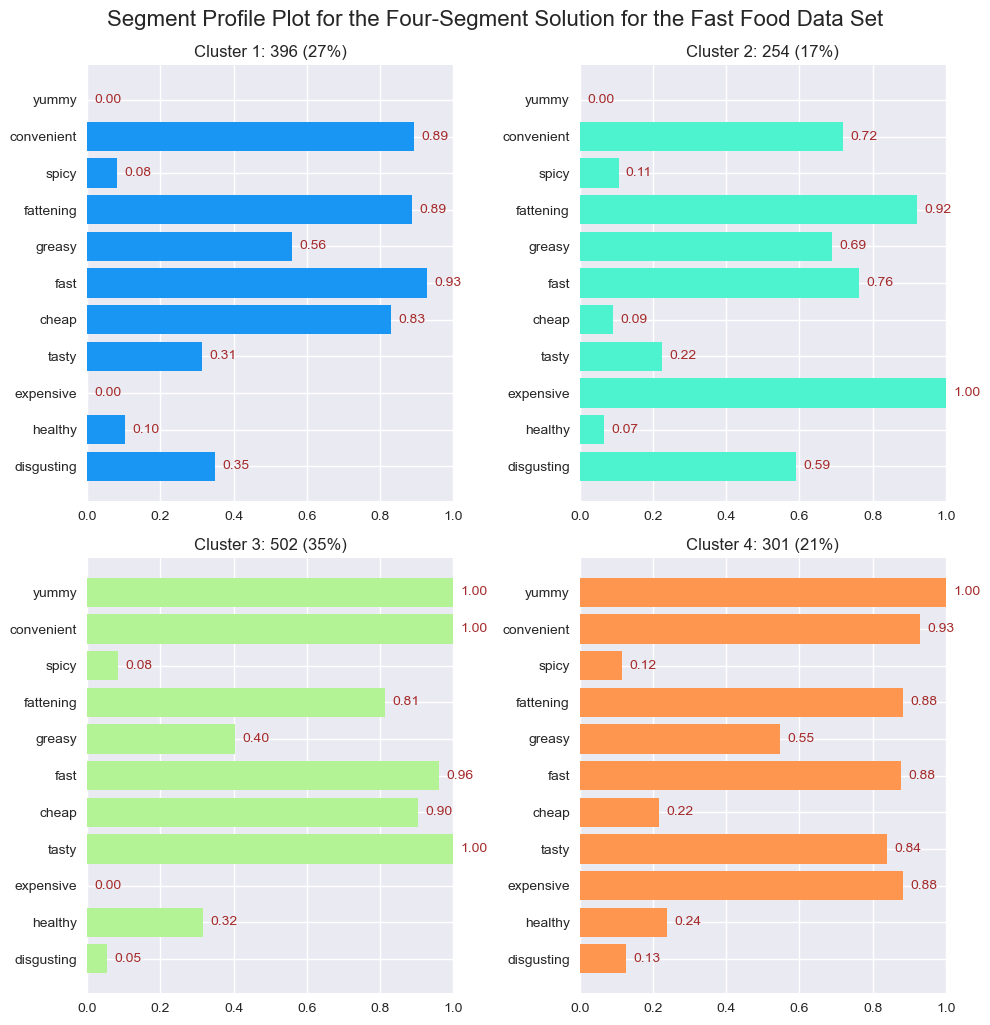

In [31]:
cluster_sizes = mcdonalds['gmm_init_km_cluster'].value_counts().sort_index()
cluster_props = cluster_sizes / len(mcdonalds)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

means = mcdonalds.groupby('gmm_init_km_cluster')[predictor_columns].mean()
colors = sns.color_palette('rainbow', n_clusters)

for cluster_num in range(n_clusters):
    cluster_data = means.loc[cluster_num]
    cluster_size = cluster_sizes[cluster_num]
    cluster_prop = cluster_props[cluster_num]
    
    axes[cluster_num].barh(predictor_columns, cluster_data, color=colors[cluster_num])
    axes[cluster_num].set_xlim(0, 1)
    axes[cluster_num].set_title(f'Cluster {cluster_num+1}: {cluster_size} ({cluster_prop:.0%})')
    axes[cluster_num].invert_yaxis()
    
    for i, v in enumerate(cluster_data):
        axes[cluster_num].text(v + 0.02, i, f'{v:.2f}', color='brown', va='center')

plt.tight_layout()
plt.suptitle('Segment Profile Plot for the Four-Segment Solution for the Fast Food Data Set', y=1.02, fontsize=16)
plt.show()

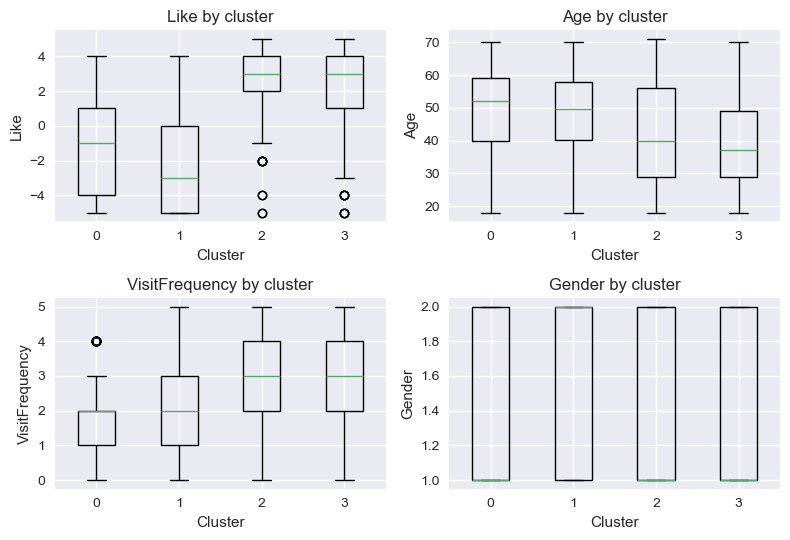

In [32]:
profile_vars = ['Like', 'Age', 'VisitFrequency', 'Gender']
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, var in enumerate(profile_vars):
    ax = axes[i]    
    data = [mcdonalds[mcdonalds['gmm_init_km_cluster'] == cluster][var] for cluster in range(n_clusters)]    
    ax.boxplot(data, labels=range(4))
    
    ax.set_title(f'{var} by cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(var)
plt.tight_layout()
plt.show()

### Cluster 1: Convenience Seekers
- **Size**: 396 (27%)
- **Insights**:
  - High preference for convenience (0.89), speed (0.93) and affordability (cheap, 0.83).
  - The food is considered fattening (0.89) and greasy (0.56), though not particularly healthy (0.10).
  - They do not find the food very tasty (0.31) or appealing (disgusting: 0.35).
- **Conclusions**
  - Convenience and Speed: This cluster highly values convenience and quick service, with preferences strongly skewed towards these attributes.
  - Affordability: They also appreciate affordability but are less concerned with the taste or healthiness of the food.
  - This group includes a wide range of ages and visit frequencies, indicating diverse lifestyles and needs.
- **Strategies** 
  - Offer a mix of fast, convenient options alongside healthier choices to cater to diverse preferences.
  - Create budget-friendly meal deals and combo offers to attract this cost-conscious segment.
  - Offer time-limited discounts during peak hours to attract more customers during these times.
  - Highlight the convenience of McDonald's locations, online ordering, and delivery options.

### Cluster 2: Health-Conscious Taste Enthusiasts
- **Size**: 254 (17%)
- **Insights**:
  - This group finds the food highly fattening (0.92), greasy (0.69), and unhealthy (0.07)
  - They do not find it particularly tasty (0.22) or appealing (disgusting: 0.59).
  - They believe the food as expensive (1.00).
  - Visits are less frequent, with a median visit frequency of 2.
- **Conclusions**:
  - They prefer non-spicy, high-quality, and convenient food but are concerned about the food being fattening, greasy, and unhealthy.
  - Their major concerns are the health implications of the food and its greasiness and fattening nature. They are not satisfied with the taste and find it somewhat disgusting.
- **Strategies**:
  - Introduce low-fat, low-grease, and nutrient-rich items to address health concerns.
  - Use higher quality, fresh ingredients to improve taste and reduce the perception of greasiness and fattiness.
  - Implement a feedback loop for healthy options and allow meal customization to cater to specific dietary preferences.

### Cluster 3: Loyal Customers
- **Size**: 502 (35%)
- **Insights**:
  - Strong preference for "yummy" (1.00), taste (tasty, 1.00), convenient (1.00), and fast (0.96) food.
  - High preference for affordability (cheap, 0.90).
  - Somewhat concerned about the healthiness (0.32) and fattiness (0.81) of the food.
  - Median "Like" score around 3, the highest among all clusters, indicating strong brand loyalty.
  - Highest visit frequency, with a median of 4.
- **Conclusions**:
  - Strong Brand Loyalty: This cluster is the largest and most loyal, frequently visiting McDonald's and having the highest "Like" scores.
  - Value for Money: They appreciate taste, convenience, speed, and affordability, making them the backbone of McDonald's customer base.
- **Strategies**:
  - Enhance the existing loyalty program with exclusive rewards, birthday offers, and personalized discounts to retain this highly satisfied segment.
  - Provide tiered rewards based on visit frequency and spending to further incentivize regular visits.
  - Encourage loyal customers to participate in feedback programs and shape future menu items and services.
  - Foster a sense of community by hosting local events, sponsorships, and collaborations with nearby schools and organizations.
  - Utilize customer data to send personalized offers and meal recommendations based on past purchases.


### Cluster 4: Quality Seekers (Health)
- **Size**: 301 (21%)
- **Insights**:
  - High preference for 'yummy' (1.0), taste (tasty, 0.84), fast (0.88) and convenience (convenient, 0.93).
  - Some concern over the healthiness (0.24) and fattiness (0.88) of the food, and affordability.
  - Median "Like" score around 3, indicating a positive perception of McDonald's.
  - High visit frequency, with a median of 4.
- **Conclusions**:
  - Quality and Taste: This cluster values taste and convenience but also considers quality and a slight preference for healthier options.
  - Positive Perception: They have a generally positive view of McDonald's, with high "Like" scores and frequent visits.
- **Suggestions**:
  - Highlight the quality of ingredients, food safety standards, and nutritional value of menu items.
  - Promote the sourcing of fresh and high-quality ingredients in marketing materials.
  - Introduce and promote healthier menu options, such as salads, wraps, and fruit sides to cater to their slight preference for healthiness.

In [33]:
# Cluster Profiling and Interpretation
for cluster_num in range(n_clusters):
    print(f'\nCluster {cluster_num + 1}:')
    cluster_data = mcdonalds[mcdonalds['gmm_init_km_cluster'] == cluster_num][profile_vars]
    print(cluster_data.describe().round(2))
    print(f'Cluster {cluster_num + 1} - Profile Interpretation:')

    print(f'Average Like: {cluster_data["Like"].mean().round(2)}')
    print(f'Average Age: {cluster_data["Age"].mean().round(2)}')
    print(f'Most common visit frequency: {cluster_data["VisitFrequency"].mode()[0]}')
    print(f'Most common gender: {cluster_data["Gender"].mode()[0]}')


Cluster 1:
         Like     Age  VisitFrequency  Gender
count  396.00  396.00          396.00  396.00
mean    -1.21   49.49            1.64    1.42
std      2.61   13.14            1.17    0.49
min     -5.00   18.00            0.00    1.00
25%     -4.00   40.00            1.00    1.00
50%     -1.00   52.00            2.00    1.00
75%      1.00   59.25            2.00    2.00
max      4.00   70.00            4.00    2.00
Cluster 1 - Profile Interpretation:
Average Like: -1.21
Average Age: 49.49
Most common visit frequency: 1
Most common gender: 1

Cluster 2:
         Like     Age  VisitFrequency  Gender
count  254.00  254.00          254.00  254.00
mean    -2.18   48.37            1.67    1.61
std      2.64   12.16            1.26    0.49
min     -5.00   18.00            0.00    1.00
25%     -5.00   40.25            1.00    1.00
50%     -3.00   49.50            2.00    2.00
75%      0.00   58.00            3.00    2.00
max      4.00   70.00            5.00    2.00
Cluster 2 - Profile 

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mcdonalds[predictor_columns])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Normalizing PCA components to the range of -1 to 1
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
principalComponents_scaled = min_max_scaler.fit_transform(principalComponents)

pca_df = pd.DataFrame(data=principalComponents_scaled, columns=['pc-1', 'pc-2'])
pca_df['cluster'] = mcdonalds['gmm_init_km_cluster']

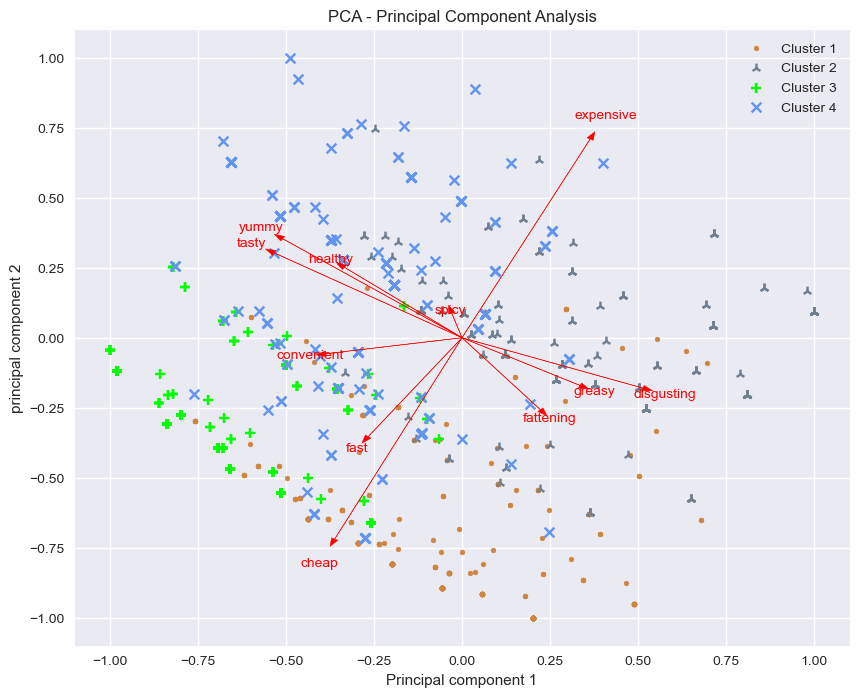

In [35]:
plt.figure(figsize=(10, 8))

colors = ['peru','slategray','lime','cornflowerblue']
markers = ['.', '2', '+', 'x']

for cluster_num in range(n_clusters):
    indices_to_keep = pca_df['cluster'] == cluster_num
    plt.scatter(
        pca_df.loc[indices_to_keep, 'pc-1'],
        pca_df.loc[indices_to_keep, 'pc-2'],
        c=colors[cluster_num],
        marker=markers[cluster_num],
        label=f'Cluster {cluster_num+1}'
    )

# arrows for original features
for i, feature in enumerate(predictor_columns):
    plt.arrow(0, 0, pca.components_[0, i] * 1.25, pca.components_[1, i] * 1.25, 
              color='red', head_width=0.02)
    plt.text(pca.components_[0, i] * 1.4, pca.components_[1, i] * 1.4, feature, 
             color='red', ha='center', va='center')

plt.xlabel('Principal component 1')
plt.ylabel('principal component 2')
plt.title('PCA - Principal Component Analysis')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

<Figure size 1200x800 with 0 Axes>

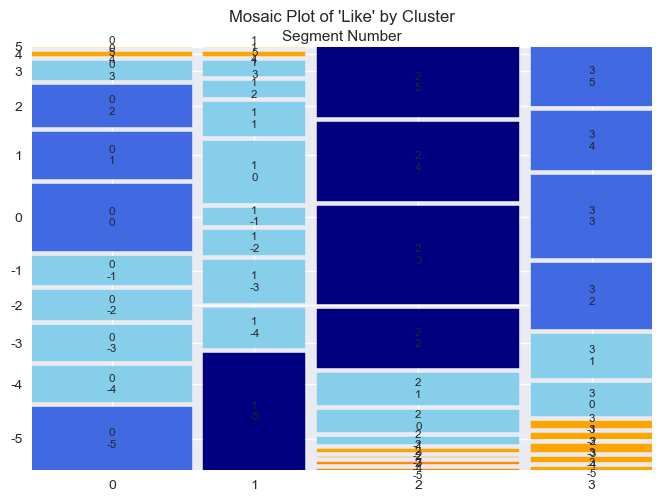

In [36]:
# Contingency table for the mosaic plot
contingency_table = pd.crosstab(mcdonalds['gmm_init_km_cluster'], mcdonalds['Like'])
residuals = contingency_table - contingency_table.values.mean()
# quantiles for shading
quantiles = residuals.stack().quantile([0.1, 0.3, 0.7, 0.9])

def mosaic_shading(key):
    cluster, like = key
    residual = residuals.at[int(cluster), int(like)]
    
    if residual > quantiles[0.9]:
        return {'color': 'navy'}
    elif residual > quantiles[0.7]:
        return {'color': 'royalblue'}
    elif residual > quantiles[0.3]:
        return {'color': 'skyblue'}
    elif residual < quantiles[0.1]:
        return {'color': 'darkorange'}
    elif residual < quantiles[0.3]:
        return {'color': 'orange'}
    elif residual < quantiles[0.7]:
        return {'color': 'peachpuff'}
    else:
        return {'color': 'white'}

plt.figure(figsize=(12, 8))
mosaic(contingency_table.stack(), gap=0.02, title='', properties=mosaic_shading)
plt.xlabel("Segment Number")
plt.ylabel("Like")
plt.title("Mosaic Plot of 'Like' by Cluster")
plt.show()

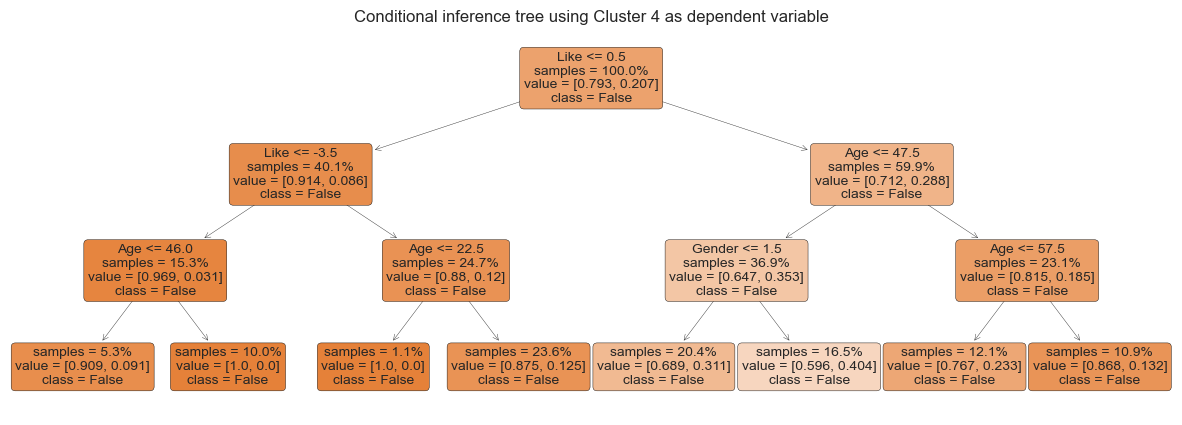

In [37]:
features = ['Like', 'Age', 'VisitFrequency', 'Gender']
target = 'gmm_init_km_cluster'

X = mcdonalds[features]
y = mcdonalds[target]

y_binary = (y == 3).astype(int)

tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=30, min_samples_leaf=10, random_state=42)
tree_clf.fit(X, y_binary)

fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(tree_clf, feature_names=features, class_names=['False', 'True'], filled=True, rounded=True, fontsize=10, proportion=True, impurity=False)

plt.title('Conditional inference tree using Cluster 4 as dependent variable')
plt.show()

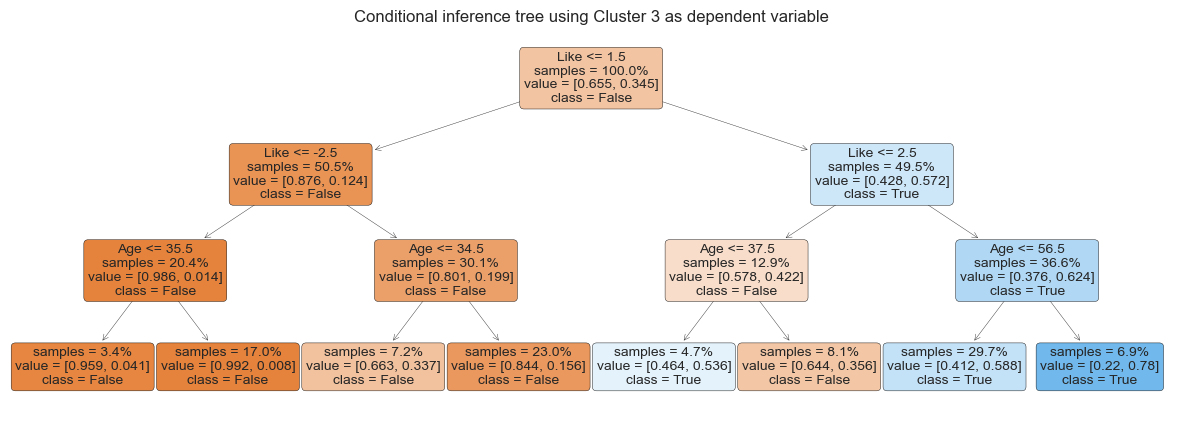

In [38]:
y_binary = (y == 2).astype(int)

tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=30, min_samples_leaf=10, random_state=42)
tree_clf.fit(X, y_binary)

fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(tree_clf, feature_names=features, class_names=['False', 'True'], filled=True, rounded=True, fontsize=10, proportion=True, impurity=False)

plt.title('Conditional inference tree using Cluster 3 as dependent variable')
plt.show()

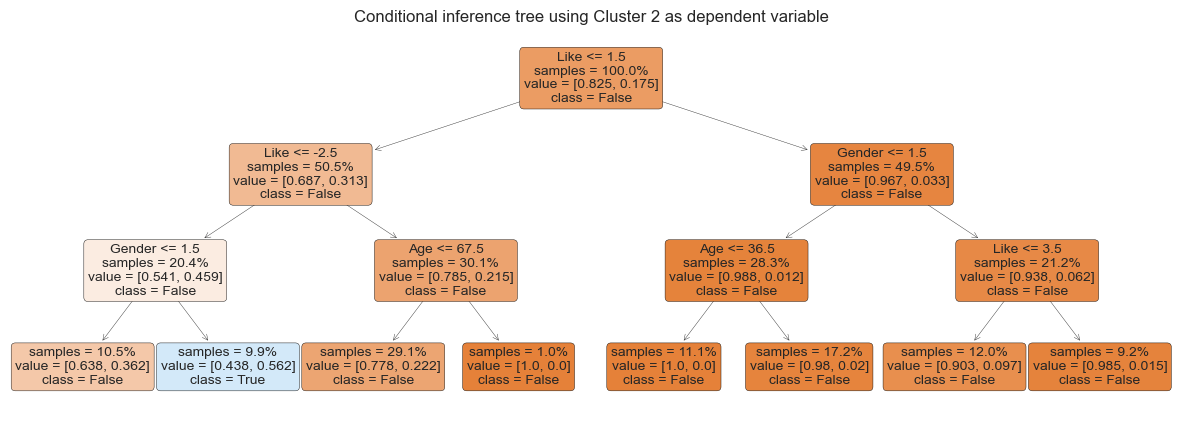

In [39]:
y_binary = (y == 1).astype(int)

tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=30, min_samples_leaf=10, random_state=42)
tree_clf.fit(X, y_binary)

fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(tree_clf, feature_names=features, class_names=['False', 'True'], filled=True, rounded=True, fontsize=10, proportion=True, impurity=False)

plt.title('Conditional inference tree using Cluster 2 as dependent variable')
plt.show()

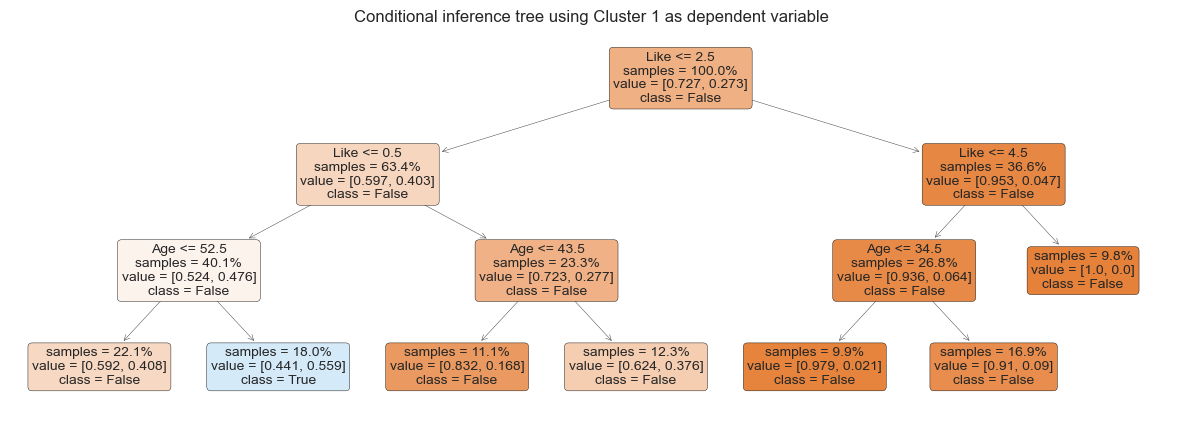

In [40]:
y_binary = (y == 0).astype(int)

tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=30, min_samples_leaf=10, random_state=42)
tree_clf.fit(X, y_binary)

fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(tree_clf, feature_names=features, class_names=['False', 'True'], filled=True, rounded=True, fontsize=10, proportion=True, impurity=False)

plt.title('Conditional inference tree using Cluster 1 as dependent variable')
plt.show()